# Time Series forecasting of Airfares

Forecasting the airfares for the period of 33 years.

Dataset link:
https://fred.stlouisfed.org/series/CUSR0000SETG01

Flow of Analysis :
1. Importing libraries
2. Understanding data
3. Exploratory Data Analysis
4. Preparation of Data
5. Time Series Decomposition
6. Building and Evaluating Time Series Forecast
7. Evaluating by changing parameters

In [148]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
import math
from scipy.stats import variation, boxcox
%matplotlib inline
sns.set_style("darkgrid")
import sklearn
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [53]:
#importing csv file and displaying its content
dataset = pd.read_csv('/content/CUSR0000SETG01.csv')
dataset.head()

,DATE,CUSR0000SETG01
0,1989-01-01,128.0
1,1989-02-01,128.6
2,1989-03-01,128.8
3,1989-04-01,129.7
4,1989-05-01,130.5


In [54]:
# print shape of dataset with rows and columns
print(dataset.shape)

(407, 2)


In [55]:
#displaying the information of the file like column_names ,its data type, etc, to get familiarized with content of the dataset:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            407 non-null    object 
 1   CUSR0000SETG01  407 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.5+ KB


Descriptive Statistics

In [56]:
dataset.describe()

,CUSR0000SETG01
count,407.000000
mean,235.482720
std,49.822652
min,128.000000
25%,200.100000
50%,238.000000
75%,274.078500
max,336.022000


Provides count, mean, max, min, etc information about the dataset.

### Exploratory Data Analysis

Finding the missing values of the dataset :

In [57]:
## displaying the list of features whose values are missing:
dataset.isnull().sum()

DATE              0
CUSR0000SETG01    0
dtype: int64

The data set has no missing data.

In [58]:
df=dataset.copy()

In [59]:
df.rename(columns={'CUSR0000SETG01': 'Fare'}, inplace=True)

In [60]:
#setting index as date
df.columns = ['Date','Fare']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df= df.set_index('Date')
df.head(10)

,Fare
Date,
1989-01-01,128.0
1989-02-01,128.6
1989-03-01,128.8
1989-04-01,129.7
1989-05-01,130.5
1989-06-01,132.0
1989-07-01,133.0
1989-08-01,133.8
1989-09-01,134.1


In [61]:
#Number of unique values
unique_val= df.nunique()
print("Uniques values in each column are:")
print(unique_val)

Uniques values in each column are:
Fare    389
dtype: int64


Outliers

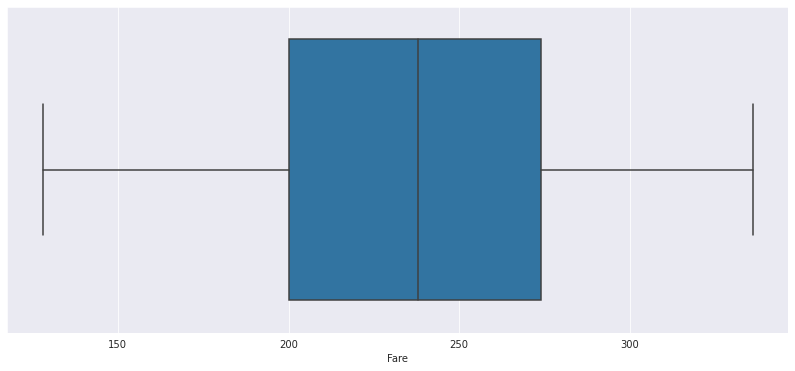

In [62]:
#Boxplot
fig = plt.subplots(figsize=(14, 6))
ax = sns.boxplot(x=df['Fare'])

There are no outliers in the dataset.

Text(0, 0.5, 'Count')

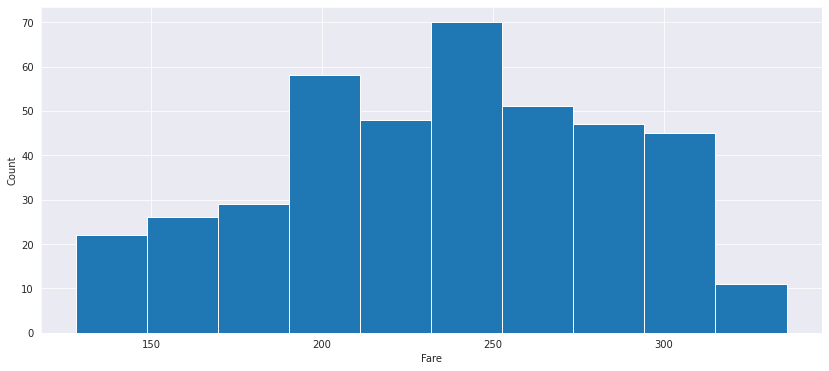

In [63]:
# Plotting Histogram
fig = df.Fare.hist(figsize = (14,6))
plt.xlabel('Fare')
plt.ylabel('Count')

The most purchased airtickes ranges between $240 and $250.

# Plotting Time Series Data

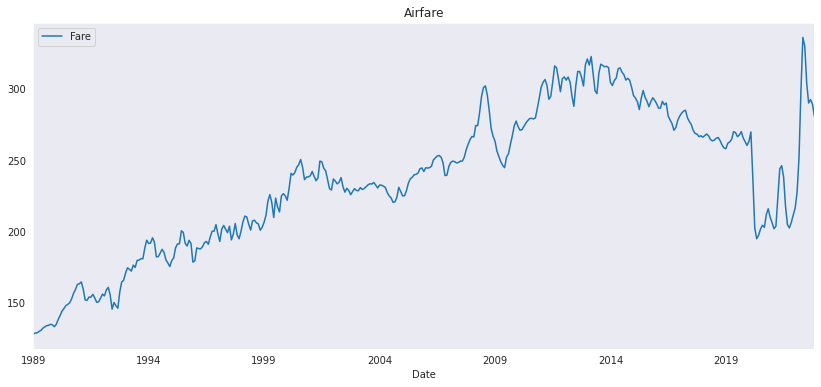

In [64]:
df.plot(figsize=(14, 6))
plt.legend(loc='best')
plt.grid()
plt.title('Airfare')
plt.show(block=False)

Linear Interpolation

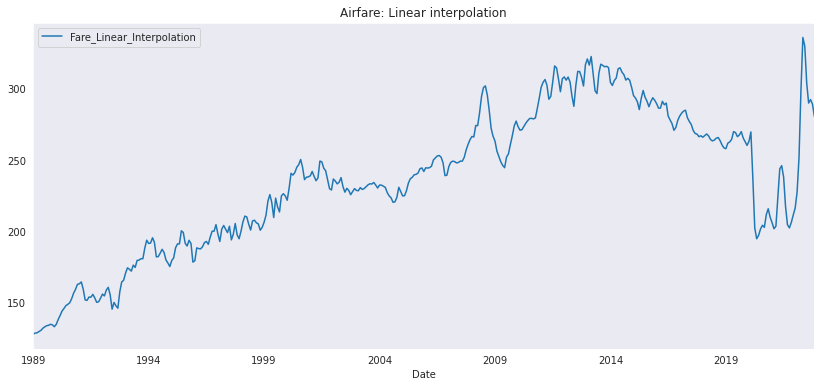

In [65]:
#generation of new values based on an existing set of values.
ds = df.assign(Fare_Linear_Interpolation=df.Fare.interpolate(method='linear'))
ds[['Fare_Linear_Interpolation']].plot(figsize=(14, 6))
plt.grid()
plt.legend(loc='best')
plt.title('Airfare: Linear interpolation')
plt.show(block=False)

A sudden drop during year 2020 and nearby time period can be justified due to crises caused by pandemic.

## Time series Decomposition

### Multiplicative seasonal decomposition

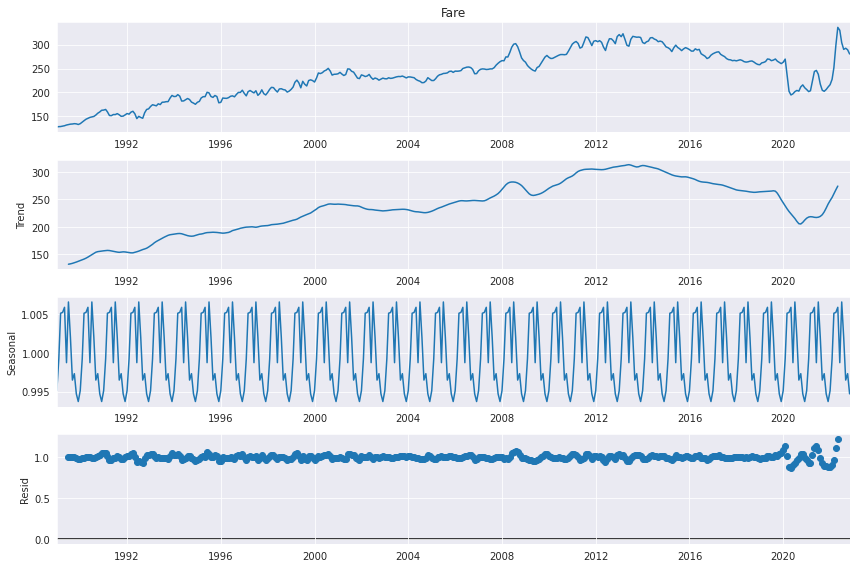

In [66]:
rcParams['figure.figsize'] = 12, 8
# multiplicative seasonal index
decompo = sm.tsa.seasonal_decompose(df.Fare, model='multiplicative')
fig = decompo.plot()
plt.show()

### Additive seasonal decomposition

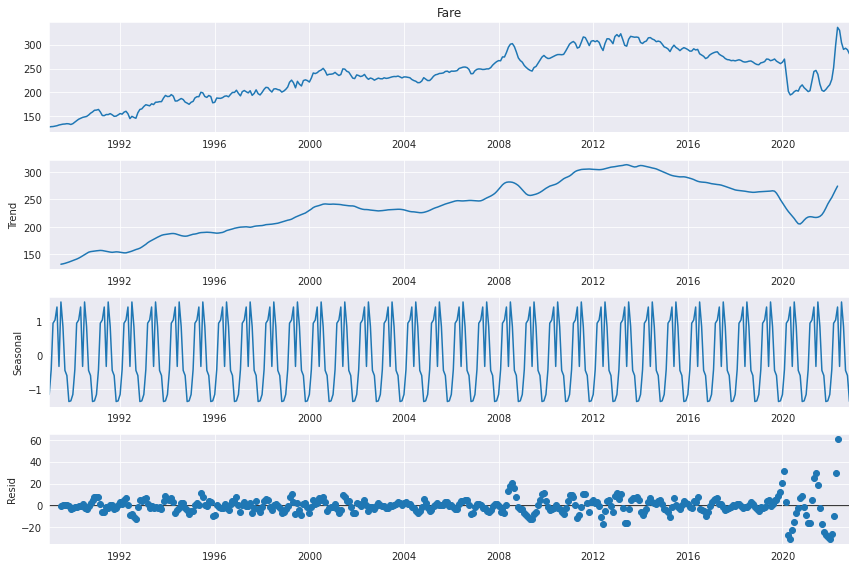

In [67]:
# additive seasonal index
decompo = sm.tsa.seasonal_decompose(df.Fare, model='additive') 
fig = decompo.plot()
plt.show()

We can infer that this data contents seasonal components.

### Auto Correlation Function (ACF)

In [68]:
#Creating lagged variables at different time steps
val = pd.DataFrame(df.Fare)
# using shift function to shift the values.
df1 = pd.concat([val.shift(3), val.shift(2), val.shift(1), val], axis=1)
df1.columns = ['t', 't+1', 't+2', 't+3']
res = df1.corr()
print(res)

            t       t+1       t+2       t+3
t    1.000000  0.991333  0.975037  0.960054
t+1  0.991333  1.000000  0.991354  0.975027
t+2  0.975037  0.991354  1.000000  0.991336
t+3  0.960054  0.975027  0.991336  1.000000


We can see the clear correlation between the variable and its previous time step.

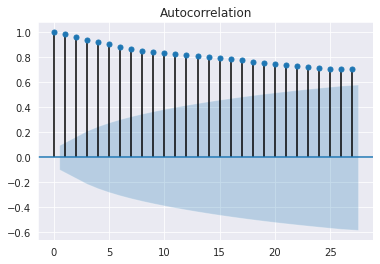

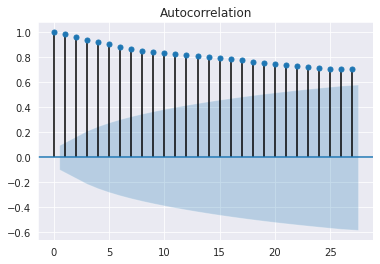

In [79]:
plot_acf(df.Fare)

###Partial autocorrelation function (PACF)

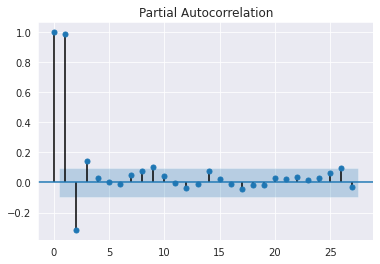

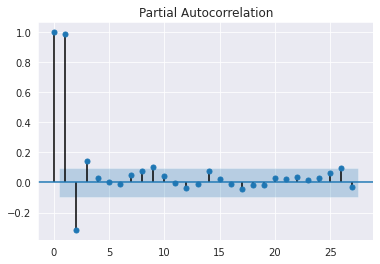

In [240]:
plot_pacf(df)

Auto correlation will be useful for us to check the significance of the future airfares depending on their previous fares.

### Checking if Time Series is stationary

In [97]:
#kpss test
kpss_test = kpss(df['Fare'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 1.678896
Critical Values @ 0.05: 0.46
p-value: 0.010000


The p-value is less than 0.05. This means that the series is not stationary.

### Performing tranformation and differencing

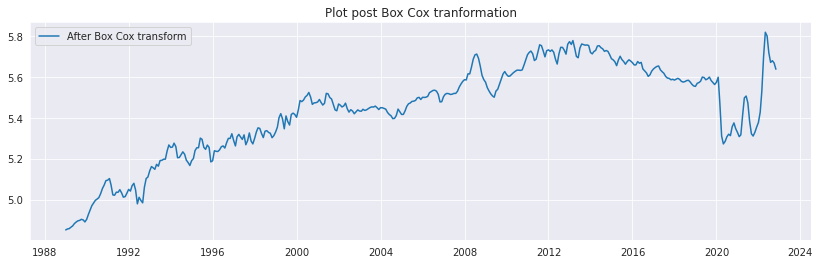

In [86]:
#to make the series stationary,Box Cox transformation is being applied to make variance constant
df_boxcox = pd.Series(boxcox(df['Fare'], lmbda=0), index = df.index)
plt.figure(figsize=(14,4))
plt.plot(df_boxcox, label='After Box Cox transform')
plt.legend(loc='best')
plt.title('Plot post Box Cox tranformation')
plt.show()

Applying differencing to the series:

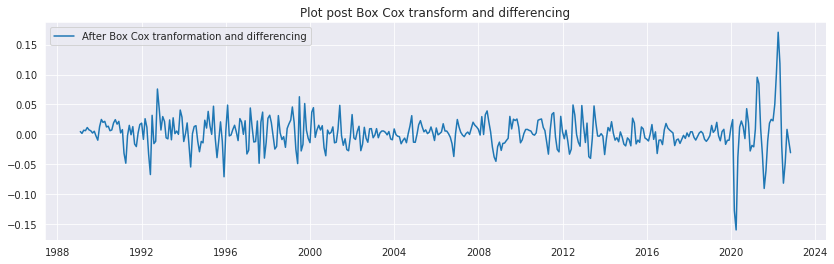

In [87]:
df_boxcox_diff = pd.Series(df_boxcox - df_boxcox.shift(), df.index)
plt.figure(figsize=(14,4))
plt.plot(df_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('Plot post Box Cox transform and differencing')
plt.show()

In [89]:
df_boxcox_diff.dropna(inplace=True)
df_boxcox_diff.tail()

Date
2022-07-01   -0.081547
2022-08-01   -0.047346
2022-09-01    0.008324
2022-10-01   -0.011058
2022-11-01   -0.030618
dtype: float64

In [98]:
#kpss re-test:
kpss_test = kpss(df_boxcox_diff)
print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])


KPSS Statistic: 0.214568
Critical Values @ 0.05: 0.46
p-value: 0.100000


The p-value is greater than 0.05. This means the series is stationary.

# Building and evaluating the time series forecast using multiple models:

### Preparing dataset into training and testing:

Splitted the traing dataset with 350 months of data and the testing has the remaining months to check its accuracy.

In [169]:
train_len = 350
train = df[0 : train_len]
test = df[train_len : ]
train_df_boxcox = df_boxcox[:train_len]
test_df_boxcox = df_boxcox[train_len:]
train_df_boxcox_diff = df_boxcox_diff[:train_len-1]
test_df_boxcox_diff = df_boxcox_diff[train_len-1:]

In [170]:
dff=df.copy()

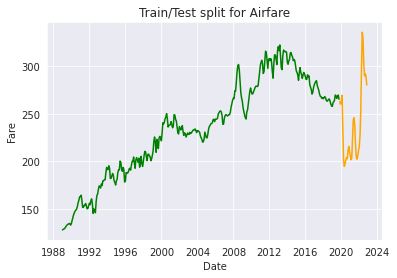

In [191]:
plt.plot(train.index, train['Fare'], color = "green")
plt.plot(test.index, test['Fare'], color = "orange") 
plt.ylabel('Fare')
plt.xlabel('Date')
#plt.xticks(rotation=45)
plt.title("Train/Test split for Airfare")
plt.show()

# Auto regressive integrated moving average (ARIMA)

This model predicts without assuming if series is stationary

In [173]:
#fitting model
m = ARIMA(train_df_boxcox, order=(1, 1, 1))
m_fit = m.fit()
print(m_fit.params)

const        0.002120
ar.L1.D.y   -0.422333
ma.L1.D.y    0.746730
dtype: float64


In [174]:
#original time series recovery
y_hat_arima = df_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = m_fit.predict(df_boxcox_diff.index.min(), df_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(df_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

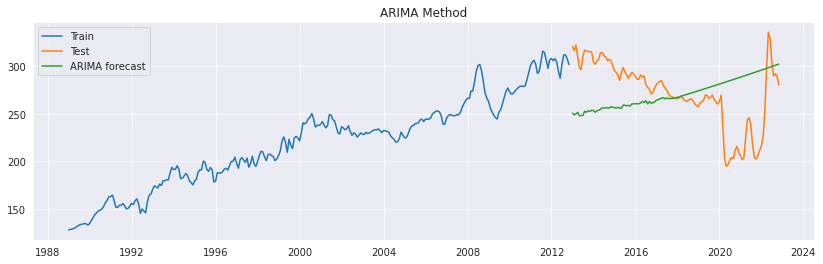

In [175]:
#plotting graph
plt.figure(figsize=(14,4))
plt.plot( train['Fare'], label='Train')
plt.plot(test['Fare'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('ARIMA Method')
plt.show()

In [176]:
#calculating RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['Fare'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Fare']-y_hat_arima['arima_forecast'][test.index.min():])/test['Fare'])*100,2)

results = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
#results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive integrated moving average (ARIM...,46.14,14.55


Lower values of RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error) indicates that a model is performing better. Accuracy is calculated as (100 — MAPE). Lower the MAPE value, higher is the accuracy.

# Seasonal auto regressive integrated moving average (SARIMA)

This model basically deals with all data values which includes all spikes, seasonality, historical values.

In [177]:
#fitting model
mm = SARIMAX(train_df_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
mm_fit = mm.fit()
print(mm_fit.params)

ar.L1      -0.909489
ma.L1       0.981107
ar.S.L12   -0.009350
ma.S.L12   -0.883017
sigma2      0.000426
dtype: float64


In [178]:
#Recover original time series forecast
y_hat_sarima = df_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = mm_fit.predict(df_boxcox_diff.index.min(), df_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

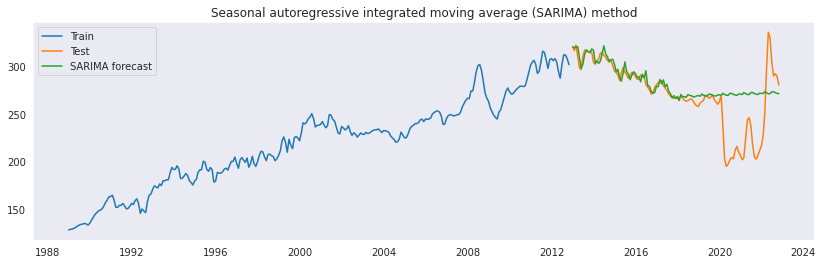

In [179]:
#plotting graph
plt.figure(figsize=(14,4))
plt.grid()
plt.plot(train['Fare'], label='Train')
plt.plot(test['Fare'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [180]:
#calculating RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['Fare'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Fare']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Fare'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive integrated moving average (ARIM...,46.14,14.55
0,Seasonal autoregressive integrated moving aver...,28.60,7.35


SARIMA model best fits this dataset as compared to ARIMA as RMSE and the MAPE values of SARIMA are very low as compared with ARIMA. And it almost predicted the values until the pandemic shock. 

## Changing train/test sets and adjusting parameters

In [276]:
train_len = 340
train = df[0 : train_len]
test = df[train_len : ]
train_df_boxcox = df_boxcox[:train_len]
test_df_boxcox = df_boxcox[train_len:]
train_df_boxcox_diff = df_boxcox_diff[:train_len-1]
test_df_boxcox_diff = df_boxcox_diff[train_len-1:]

###ARIMA

In [232]:
#fitting model
m = ARIMA(train_df_boxcox, order=(0, 1, 0))
m_fit = m.fit()
print(m_fit.params)
#original time series recovery
y_hat_arima = df_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = m_fit.predict(df_boxcox_diff.index.min(), df_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(df_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

const    0.002361
dtype: float64


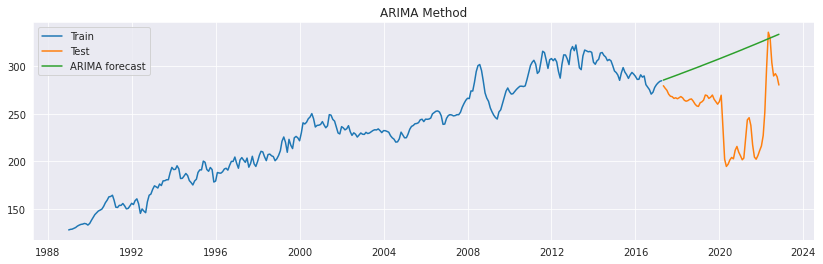

In [233]:
#plotting graph
plt.figure(figsize=(14,4))
plt.plot( train['Fare'], label='Train')
plt.plot(test['Fare'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('ARIMA Method')
plt.show()

In [234]:
#calculating RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['Fare'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Fare']-y_hat_arima['arima_forecast'][test.index.min():])/test['Fare'])*100,2)

results = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
#results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive integrated moving average (ARIM...,68.85,25.29


SARIMA

In [277]:
#fitting model
mm = SARIMAX(train_df_boxcox, order=(1, 0, 1), seasonal_order=(2, 0, 1, 12)) 
mm_fit = mm.fit()
print(mm_fit.params)
#Recover original time series forecast
y_hat_sarima = df_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = mm_fit.predict(df_boxcox_diff.index.min(), df_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

ar.L1       0.998557
ma.L1       0.402751
ar.S.L12    1.018566
ar.S.L24   -0.022619
ma.S.L12   -0.969068
sigma2      0.000381
dtype: float64


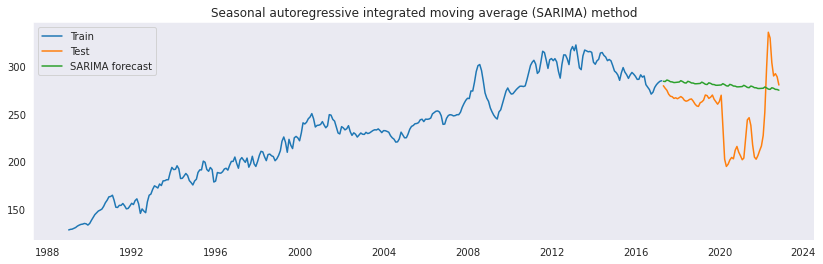

In [278]:
#plotting graph
plt.figure(figsize=(14,4))
plt.grid()
plt.plot(train['Fare'], label='Train')
plt.plot(test['Fare'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [279]:
#calculating RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['Fare'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Fare']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Fare'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive integrated moving average (ARIM...,68.85,25.29
0,Seasonal autoregressive integrated moving aver...,43.16,10.60
0,Seasonal autoregressive integrated moving aver...,47.75,16.50
0,Seasonal autoregressive integrated moving aver...,46.43,15.63
0,Seasonal autoregressive integrated moving aver...,48.97,16.06
0,Seasonal autoregressive integrated moving aver...,59.36,18.42
0,Seasonal autoregressive integrated moving aver...,43.38,15.42


Changing the test dataset and train dataset ratio didnot improve the model, though changes were seen when other parameters were changed.

Can infer from above analysis that, the Airfares were forcasted using SARIMA model, because of the seasonal data content.